# K-Means with Elbows and Silhouette Score

Tram Duong
<br>October 12, 2020


### Part 1: EDA and FE 
- Data Exploration
- Data Cleaning
- Feature Engineerings

In [1]:
import pandas as pd 
import seaborn as sns  
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import scipy 
from scipy import stats
sns.set(rc={'figure.figsize':(10,15)})

In [2]:
# read data 
payment_data = pd.read_csv("/data/inpatientCharges.csv")

Few notices from the data overview:
   - Payments should be in numeric/float format to do statistics 
   - Zipcode column should be in character/object format
   - Provider ID should be in int format

In [3]:
payment_data.head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,$32963.07,$5777.24,$4763.73
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,$15131.85,$5787.57,$4976.71
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,$37560.37,$5434.95,$4453.79
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,$13998.28,$5417.56,$4129.16
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,$31633.27,$5658.33,$4851.44


In [4]:
payment_data.describe()

,Provider Id,Provider Zip Code,Total Discharges
count,163065.000000,163065.000000,163065.000000
mean,255569.865428,47938.121908,42.776304
std,151563.671767,27854.323080,51.104042
min,10001.000000,1040.000000,11.000000
25%,110092.000000,27261.000000,17.000000
50%,250007.000000,44309.000000,27.000000
75%,380075.000000,72901.000000,49.000000
max,670077.000000,99835.000000,3383.000000


In [5]:
payment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163065 entries, 0 to 163064
Data columns (total 12 columns):
DRG Definition                          163065 non-null object
Provider Id                             163065 non-null int64
Provider Name                           163065 non-null object
Provider Street Address                 163065 non-null object
Provider City                           163065 non-null object
Provider State                          163065 non-null object
Provider Zip Code                       163065 non-null int64
Hospital Referral Region Description    163065 non-null object
 Total Discharges                       163065 non-null int64
 Average Covered Charges                163065 non-null object
 Average Total Payments                 163065 non-null object
Average Medicare Payments               163065 non-null object
dtypes: int64(3), object(9)
memory usage: 14.9+ MB


According to the link: https://data.cms.gov/Medicare-Inpatient/National-Summary-of-Inpatient-Charge-Data-by-Medic/efwk-h4x3, the dataset description is below:

**DRG Definition** : Classification system that groups similar clinical conditions (diagnoses) and the procedures furnished by the hospital during the stay.

**Total Discharges** : The number of discharges billed by all providers for inpatient hospital services.

**Average Covered Charges** : The average charge of all provider's services covered by Medicare for discharges in the DRG. These will vary from hospital to hospital because of differences in hospital charge structures.

**Average Total Payment**: The average total payments to all providers for the DRG including the MS-DRG amount, teaching, disproportionate share, capital, and outlier payments for all cases. Also included in average total payments are co-payment and deductible amounts that the patient is responsible for and any additional payments by third parties for coordination of benefits.

**Average Medicare Payment**: The average amount that Medicare pays to the provider for Medicare's share of the MS-DRG. Medicare payment amounts include the MS-DRG amount, teaching, disproportionate share, capital, and outlier payments for all cases. Medicare payments DO NOT include beneficiary co-payments and deductible amounts nor any additional payments from third parties for coordination of benefits.


### Preprocessing data

Some columns names have spaces which need to be removed

In [6]:
payment_data.columns

Index(['DRG Definition', 'Provider Id', 'Provider Name',
       'Provider Street Address', 'Provider City', 'Provider State',
       'Provider Zip Code', 'Hospital Referral Region Description',
       ' Total Discharges ', ' Average Covered Charges ',
       ' Average Total Payments ', 'Average Medicare Payments'],
      dtype='object')

In [7]:
payment_data.columns = payment_data.columns.str.strip()

All the payment columns include '$' sign which need to be removed and coverted to float type for further analysis

In [8]:
# remove $ sign and convert to float type
payment_data['Average Covered Charges'] = payment_data['Average Covered Charges'].str.strip("$").astype('float')
payment_data['Average Total Payments'] = payment_data['Average Total Payments'].str.strip("$").astype('float')
payment_data['Average Medicare Payments'] = payment_data['Average Medicare Payments'].str.strip("$").astype('float')

Zipcode column contain some 4 digits values which need to converted into the right type as they are missing the leading zero.

In [9]:
payment_data['Provider Zip Code'] = payment_data['Provider Zip Code'].astype(str).str.zfill(5)

### Exploratory Data Analysis

The dataset contains payments of inpatients in 50 states. Beside making visualizations for comparing the amount of charges in different states, I plan to build some visualization based on regions to gain more insights. 

In [10]:
west = ['WA','OR','CA','ID','NV','MT','WY','UT','AZ','CO','NM']
midwest = ['ND','MN','WI','MI','SD','NE','KS','IA','MO','IL','IN','OH']
south = ['TX','OK','AR','LA','MS','TN','KY','AL','GA','FL','SC','NC','VA','WV','MD','DE']
northeast = ['PA','NJ','NY','CT','MA','RI','VT','NH','ME']

In [11]:
s=pd.DataFrame([west,midwest,south,northeast],index=['West','Midwest','South','Northeast'])
s=s.reset_index().melt('index')
payment_data['Region'] = payment_data['Provider State'].map(dict(zip(s['value'],s['index'])))

In [12]:
payment_data.head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Region
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,South
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,South
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,South
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16,South
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44,South


### Visualization by states

<Figure size 1152x720 with 0 Axes>

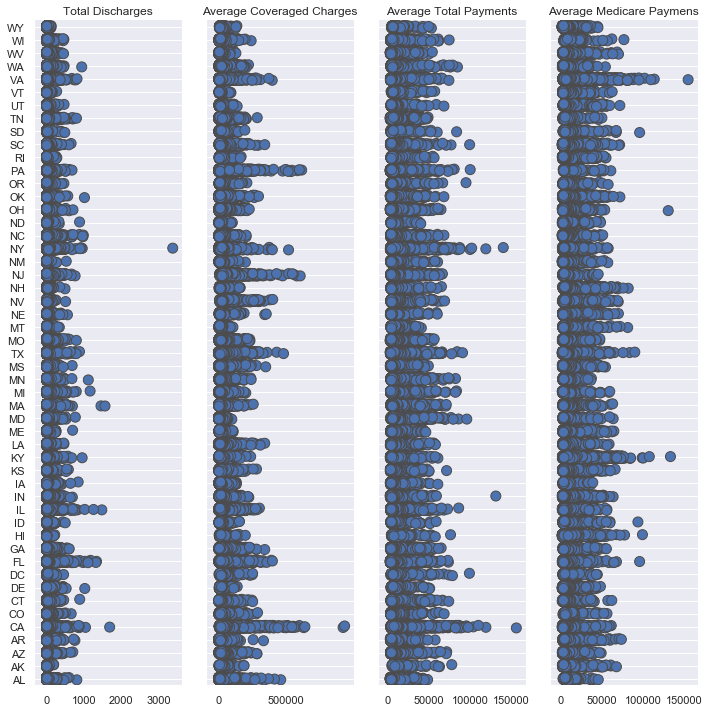

In [13]:
# Make the PairGrid
fig = plt.figure(figsize=(16,10))
g = sns.PairGrid(payment_data,
                 x_vars=['Total Discharges', 'Average Covered Charges', 'Average Total Payments', 'Average Medicare Payments'], 
                 y_vars=["Provider State"],
                 height=10, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", linewidth=1)

# Use the same x axis limits on all columns and add better labels
g.set(xlabel="", ylabel="")

# Use semantically meaningful titles for the columns
titles = ["Total Discharges", "Average Coveraged Charges", "Average Total Payments",
          "Average Medicare Paymens"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

### Visualization by regions

<Figure size 1152x720 with 0 Axes>

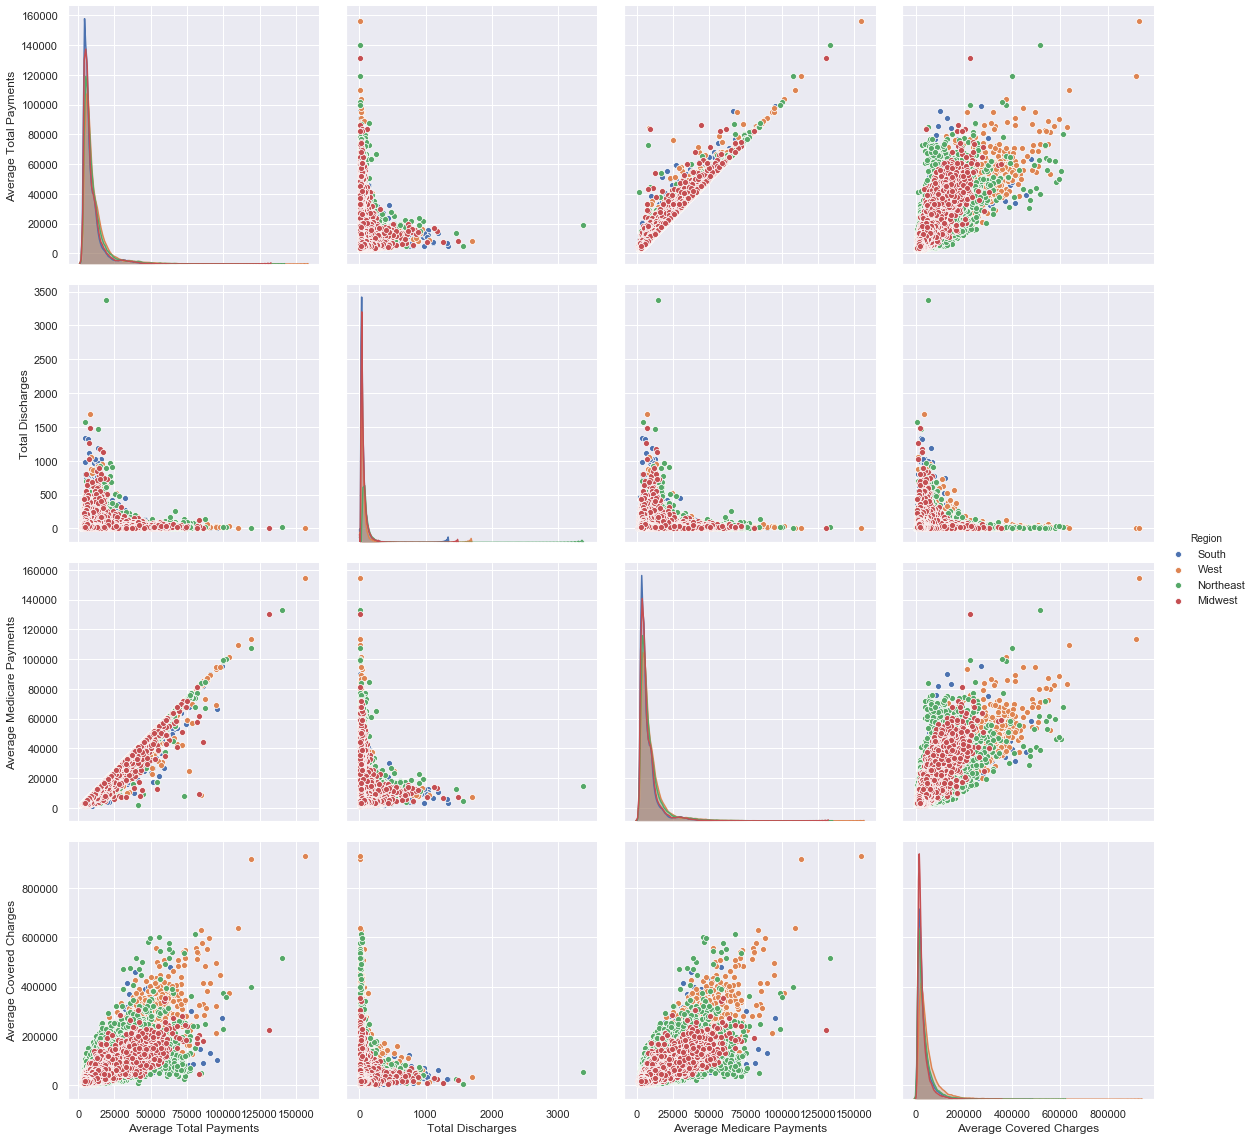

In [14]:
fig = plt.figure(figsize=(16,10))
sns.pairplot(payment_data[['Region','Average Total Payments',
                            'Total Discharges','Average Medicare Payments','Average Covered Charges']], hue= 'Region',height = 4)

### Feature Correlation

In [15]:
stats_df = pd.DataFrame(payment_data, columns=['Average Total Payments',
                            'Total Discharges','Average Medicare Payments','Average Covered Charges'])

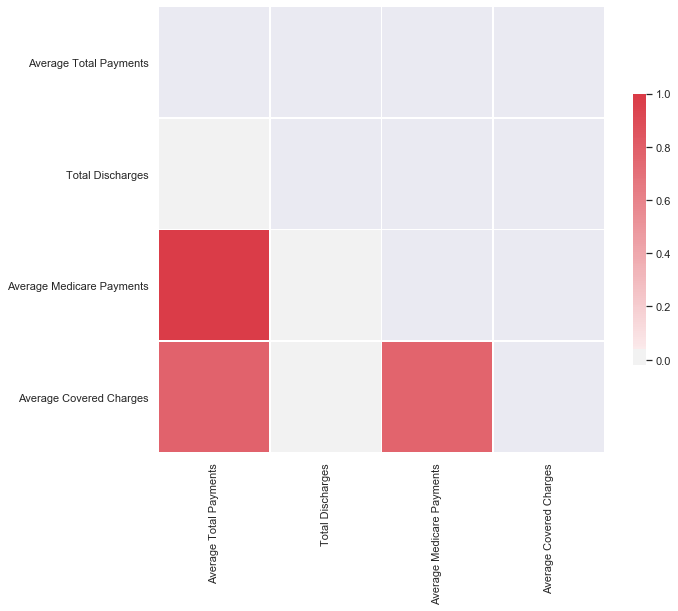

In [16]:
x = stats_df
corr = x.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The average medicare payments and average covered charges are highly correlated to each other. Furthermore, the average medicare payments are also highly correlated with the average total payments.   

### Common Procedures

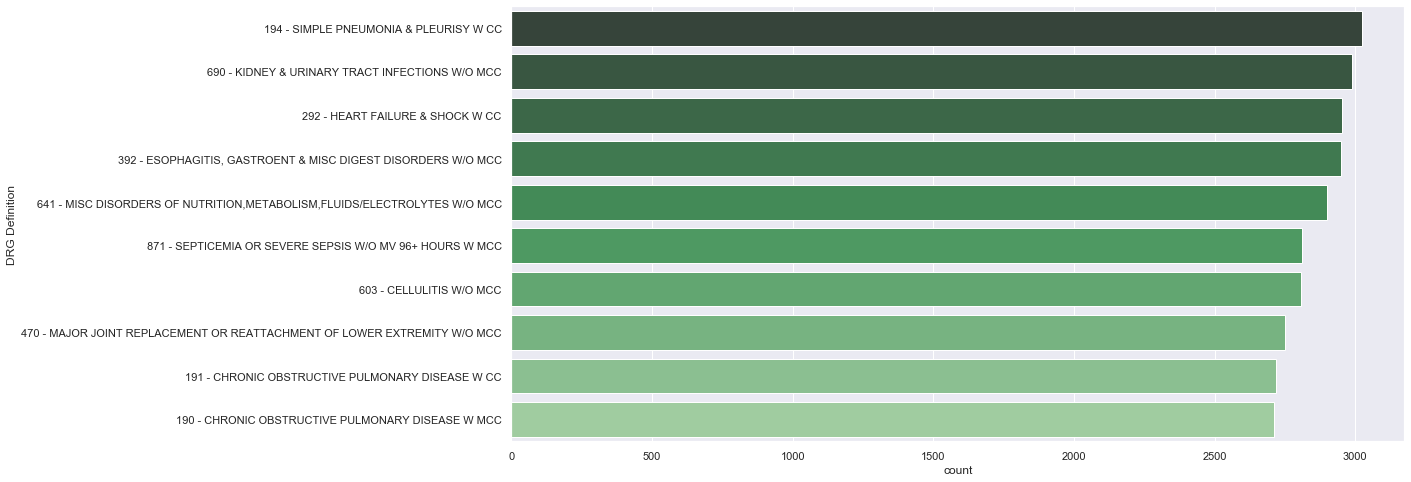

In [17]:
fig = plt.figure(figsize=(16,8))
common_drg = payment_data.groupby('DRG Definition').count()['Provider Id'].sort_values(ascending=False)
top_10 = common_drg[:10]
sns.countplot(y='DRG Definition', data=payment_data, palette="Greens_d",
              order=pd.value_counts(payment_data['DRG Definition']).iloc[:10].index)

### Features Engineering 

#### 1:  Patient Average by Provider ID

This feature will provide an estimation of the average amount charges/payment by each provider.

In [18]:
# gorup by id 
patient_avg_id = payment_data.groupby('Provider Id').mean()[['Total Discharges',
                                    'Average Covered Charges','Average Total Payments','Average Medicare Payments']]
patient_avg_id.head()

,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
Provider Id,,,,
10001,58.750000,35247.028152,8749.025109,7678.214348
10005,28.959184,16451.092041,6812.131224,5793.631429
10006,45.360465,36942.357442,8197.237907,7145.959535
10007,27.409091,12079.536818,4860.829091,4047.025455
10008,17.888889,16148.752222,5898.136667,4963.547778


**Conclusion**: This feature shows the average charge/payment of each provider which can be used as a baseline when there is any unsual amount. This insight highlights the business use of this feature and shows how it will be helpful with detecting anomalies.

#### 2: Patient Average by State

This feature will provide an estimation of the average amount charges/payment in each state.

In [19]:
patient_avg_state = payment_data.groupby('Provider State').mean()[['Total Discharges',
                                    'Average Covered Charges','Average Total Payments','Average Medicare Payments']]
patient_avg_state.head()

,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
Provider State,,,,
AK,26.588745,40348.743333,14572.391732,12958.969437
AL,39.258322,31316.462074,7568.232149,6418.007120
AR,41.978229,26174.526246,8019.248805,6919.720832
AZ,36.690284,41200.063020,10154.528211,8825.717240
CA,36.357854,67508.616536,12629.668472,11494.381678


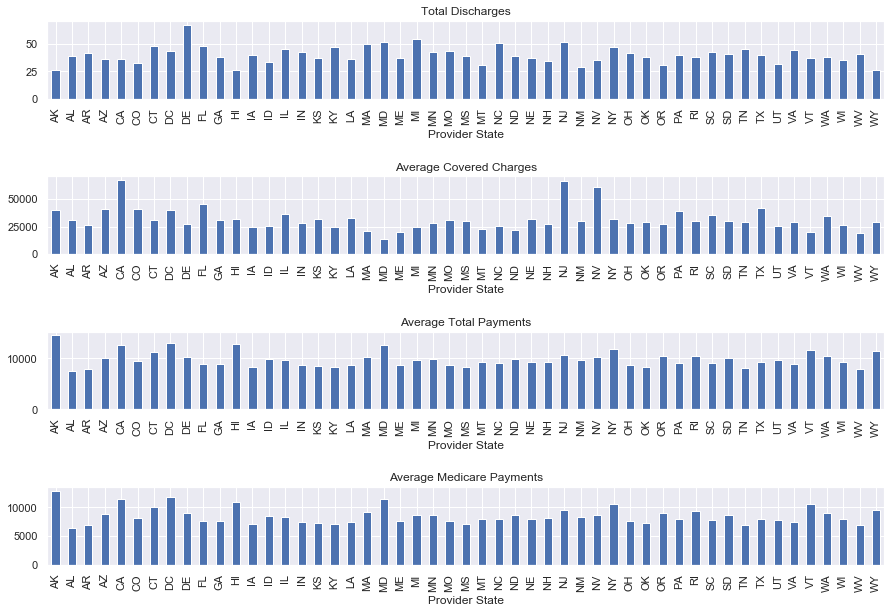

In [20]:
fig, axes = plt.subplots(nrows=4, ncols=1,figsize=(15,10))
plt.subplots_adjust(hspace=1)
for i, ax in enumerate(axes.flatten()):
    patient_avg_state[patient_avg_state.columns[i]].plot(kind='bar',ax=ax)
    ax.set_title(patient_avg_state.columns[i])

**Conclusion**: This feature will provide an estimation of the average amount charges/payment in each state which can be used to compare between states and treated as a baseline when there is any unsual amount. This insight highlights the business use of this feature and shows how it will be helpful with detecting anomalies. 

#### 3: Patient Average by Region
This feature displays the average amount charges/payment in each region

In [21]:
patient_avg_reg = payment_data.groupby('Region').mean()[['Total Discharges',
                                    'Average Covered Charges','Average Total Payments','Average Medicare Payments']]

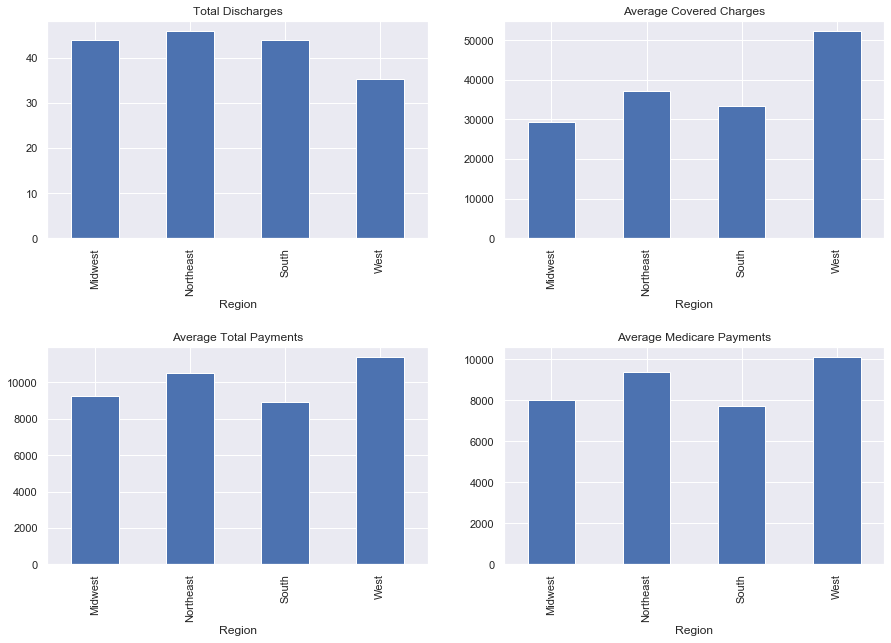

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
plt.subplots_adjust(hspace=0.5)
for i, ax in enumerate(axes.flatten()):
    patient_avg_reg[patient_avg_reg.columns[i]].plot(kind='bar',ax=ax)
    ax.set_title(patient_avg_reg.columns[i])

**Conclusion**: This feature will provide an estimation of the average amount charges/payment in each region which can be used to compare between them and treated as a baseline when there is any unsual amount in each region. This insight highlights the business use of this feature and shows how it will be helpful with detecting anomalies.

#### 4: Average out of pocket by provider name
This feature is the amount that patient pay by different provider. It gives us an idea which provider has the greatest charges.

In [23]:
payment_data['Ave Out of Pocket Payment'] = payment_data['Average Total Payments'] - payment_data['Average Medicare Payments']

In [24]:
oop_pro= payment_data[['Provider Name', 'Ave Out of Pocket Payment']].groupby(by='Provider Name').agg('mean')
oop_pro = oop_pro.sort_values(('Ave Out of Pocket Payment'), ascending=False)
oop_pro.head()

,Ave Out of Pocket Payment
Provider Name,
BAYLOR SURGICAL HOSPITAL AT FORT WORTH,14853.560000
CANCER TREATMENT CENTERS OF AMERICA,9613.663333
USMD HOSPITAL AT FORT WORTH LP,9169.745000
IRVING COPPELL SURGICAL HOSPITAL LLP,8728.920000
UVA HEALTH SCIENCES CENTER,8715.730000


Text(0.5, 0, 'Ave OoP per discharge')

<Figure size 2160x1440 with 0 Axes>

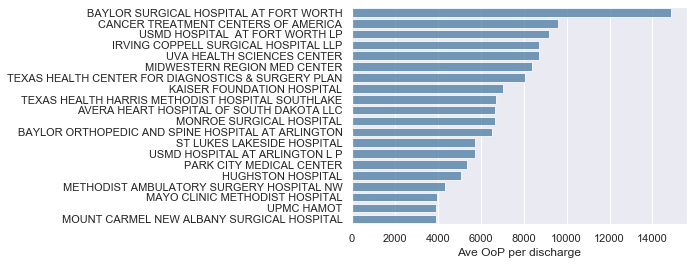

In [25]:
%%capture --no-stdout --no-display output 
#Stop warning from showing

# Top 20 out of pocket per provider

a =  oop_pro[:20]
plt.figure(figsize=(30,20))
fig,ax= plt.subplots()
fig = sns.barplot(a.iloc[:,0],a.index, color="steelblue",alpha=0.8)
ax.set(ylabel=None)
plt.xlabel("Ave OoP per discharge")

**Conclusion**: Out of pocket is an important indicator for any hospital bill. This feature helps to define the mean of average out of pocket payment in each provider and can be used as a baseline to compare when any out of pocket charges occur.

#### 5: Out of pocket by procedures
This feature is the amount that patient pay by different procedures. It gives us an estimate amount for different procedures

In [26]:
oop_drg= payment_data[['DRG Definition', 'Ave Out of Pocket Payment']].groupby(by='DRG Definition').agg('mean')
oop_drg = oop_drg.sort_values(('Ave Out of Pocket Payment'), ascending=False)
oop_drg.head()

,Ave Out of Pocket Payment
DRG Definition,
460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,3735.070150
473 - CERVICAL SPINAL FUSION W/O CC/MCC,2594.714232
247 - PERC CARDIOVASC PROC W DRUG-ELUTING STENT W/O MCC,2582.521719
207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR SUPPORT 96+ HOURS,2559.372528
853 - INFECTIOUS & PARASITIC DISEASES W O.R. PROCEDURE W MCC,2497.221490


Text(0.5, 0, 'Ave OoP by Procedure')

<Figure size 2160x1440 with 0 Axes>

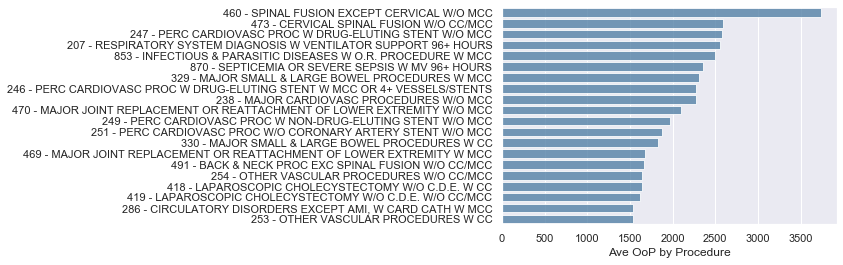

In [27]:
%%capture --no-stdout --no-display output
# prevent warning message from showing

# Top 20 out of pocket by procedure
a =  oop_drg[:20]
plt.figure(figsize=(30,20))
fig,ax= plt.subplots()
fig = sns.barplot(a.iloc[:,0],a.index, color="steelblue",alpha=0.8)
ax.set(ylabel=None)
plt.xlabel("Ave OoP by Procedure")

**Conclusion**: This feature helps to define the mean of average out of pocket payment in each procedures and can be used as a baseline to detect anomalies.

#### 6: Ave out of pocket per discharge

This feature shows the average amount of out of pocket per discharge for different procedures. If there are a high amount of charge occuring, they would be captured to possibily be investigated if needed.

In [28]:
payment_data['Ave OoP per discharge'] = payment_data['Ave Out of Pocket Payment']/payment_data['Total Discharges']

In [29]:
oop_dis= payment_data[['DRG Definition', 'Ave OoP per discharge']].groupby(by='DRG Definition').agg('mean')
oop_dis = oop_dis.sort_values(('Ave OoP per discharge'), ascending=False)
oop_dis.head()

,Ave OoP per discharge
DRG Definition,
207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR SUPPORT 96+ HOURS,136.913806
460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,128.522544
473 - CERVICAL SPINAL FUSION W/O CC/MCC,126.851226
870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS,121.497520
329 - MAJOR SMALL & LARGE BOWEL PROCEDURES W MCC,113.064950


Text(0.5, 0, 'Ave OoP per discharge')

<Figure size 2160x1440 with 0 Axes>

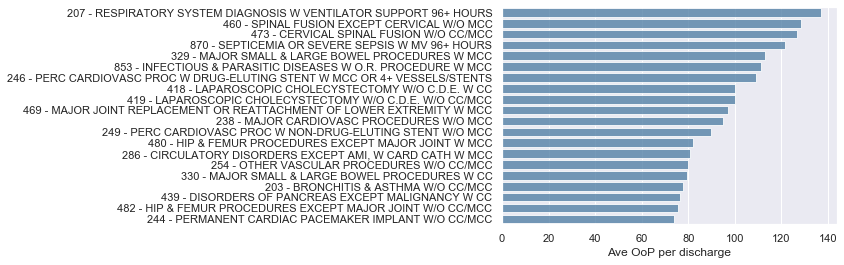

In [30]:
%%capture --no-stdout --no-display output
# prevent warning message from showing

# Top 20 out of pocket per discharge
a =  oop_dis[:20]
plt.figure(figsize=(30,20))
fig,ax= plt.subplots()
fig = sns.barplot(a.iloc[:,0],a.index, color="steelblue",alpha=0.8)
ax.set(ylabel=None)
plt.xlabel("Ave OoP per discharge")

**Conclusion**: This feature helps to define the mean of average out of pocket payment per discharge for each procedure and can be used as a baseline to detect anomaly. If a discharge pay a big difference amount from the mean for specific procedure, it would be noticable

#### 7: Percent of payment covered
This feature displays the proportion of the total payment compared to covered charge.

In [31]:
payment_data['Percent of Payment Covered'] = round((payment_data['Average Total Payments'] / 
                                                    payment_data['Average Covered Charges'])*100,2)
payment_data['Percent of Payment Covered'].head()

0    17.53
1    38.25
2    14.47
3    38.70
4    17.89
Name: Percent of Payment Covered, dtype: float64

In [32]:
pc_per= payment_data[['DRG Definition', 'Percent of Payment Covered']].groupby(by='DRG Definition').agg('mean')
pc_per = pc_per.sort_values(('Percent of Payment Covered'), ascending=False)
pc_per.head()

,Percent of Payment Covered
DRG Definition,
885 - PSYCHOSES,44.798483
603 - CELLULITIS W/O MCC,38.141585
897 - ALCOHOL/DRUG ABUSE OR DEPENDENCE W/O REHABILITATION THERAPY W/O MCC,37.399592
292 - HEART FAILURE & SHOCK W CC,37.206478
871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ HOURS W MCC,37.103869


Text(0.5, 0, 'Percent of Payment Covered')

<Figure size 2160x1440 with 0 Axes>

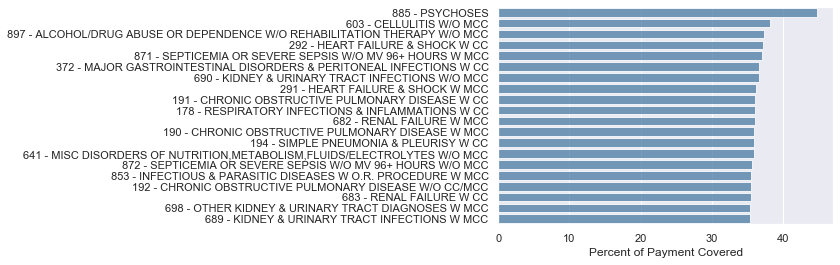

In [33]:
%%capture --no-stdout --no-display output
# prevent warning message from showing

# Top 20 highest percent of payment covered
a =  pc_per[:20]
plt.figure(figsize=(30,20))
fig,ax= plt.subplots()
fig = sns.barplot(a.iloc[:,0],a.index, color="steelblue",alpha=0.8)
ax.set(ylabel=None)
plt.xlabel("Percent of Payment Covered")

**Conclusion**: This feature helps to define the percent of payment covered and can be used as a baseline to detect anomaly. If an unsual percentage of payment for a procedure occurs, it would be noticable.

#### 8: Medicare coverage ratio

This feature calculates the proportion covered by medicare for different procedures

In [34]:
payment_data['Medicare Coverage Ratio'] = (payment_data['Average Medicare Payments'] / payment_data['Average Total Payments'])

In [35]:
med_cv = payment_data[['DRG Definition', 'Medicare Coverage Ratio']].groupby(by='DRG Definition').agg('mean')
med_cv = med_cv.sort_values(('Medicare Coverage Ratio'), ascending=True)
med_cv.head()

,Medicare Coverage Ratio
DRG Definition,
310 - CARDIAC ARRHYTHMIA & CONDUCTION DISORDERS W/O CC/MCC,0.717772
203 - BRONCHITIS & ASTHMA W/O CC/MCC,0.719805
313 - CHEST PAIN,0.727650
390 - G.I. OBSTRUCTION W/O CC/MCC,0.732743
149 - DYSEQUILIBRIUM,0.742108


Text(0.5, 0, 'Medicare Coverage Ratio')

<Figure size 1440x1440 with 0 Axes>

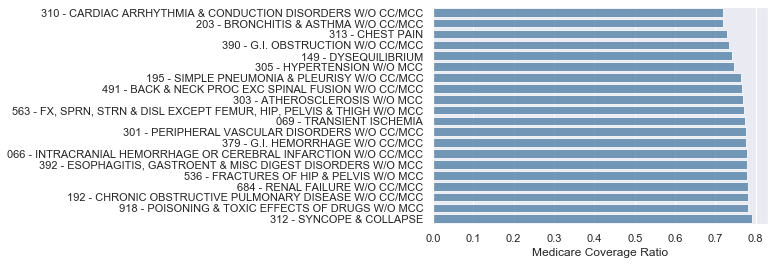

In [36]:
%%capture --no-stdout --no-display output
# prevent warning message from showing

# Top 20 highest medicare covered
a =  med_cv[:20]
plt.figure(figsize=(20,20))
fig,ax= plt.subplots()
fig = sns.barplot(a.iloc[:,0],a.index, color="steelblue",alpha=0.8)
ax.set(ylabel=None)
plt.xlabel("Medicare Coverage Ratio")

**Conclusion**: This feature helps to define the percent of medicare coverage for each procedure and can be used as a baseline to detect anomaly. If an unsual percentage of medicare charges for a procedure occurs, it would be noticable.

#### 9: Medicare coverage ratio by state
This feature displays the average percentage covered by medicare in each state

In [37]:
med_cv_state = payment_data[['Provider State', 'Medicare Coverage Ratio']].groupby(by='Provider State').agg('mean')
med_cv_state = med_cv_state.sort_values(('Medicare Coverage Ratio'), ascending=False)
med_cv_state.head()

,Medicare Coverage Ratio
Provider State,
MD,0.888943
CA,0.885084
DC,0.884320
VT,0.874861
MA,0.872525


Text(0.5, 0, 'Medicare Coverage Ratio')

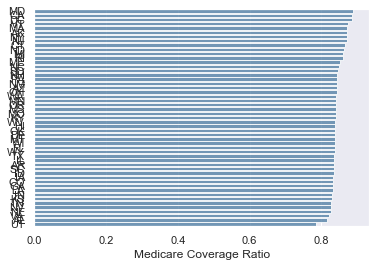

In [38]:
%%capture --no-stdout --no-display output
# prevent warning message from showing

fig,ax= plt.subplots()
fig = sns.barplot(med_cv_state.iloc[:,0],med_cv_state.index,color="steelblue",alpha=0.8)
ax.set(ylabel=None)
plt.xlabel("Medicare Coverage Ratio")

**Conclusion**: This feature helps to define the percent of medicare coverage in each state and can be used as a baseline to detect anomalies. If an unsual percentage of medicare happens, it would be noticable

###  Z-score 
Z-scores can quantify the unusualness of an observation when your data follow the normal distribution. Z-scores are the number of standard deviations above and below the mean that each value falls. For example, a Z-score of 2 indicates that an observation is two standard deviations above the average while a Z-score of -2 signifies it is two standard deviations below the mean. A Z-score of zero represents a value that equals the mean.

An absolute Z-score greater than 3 are an outlier/anomaly as they fall outside 99.7% of the data.


#### 10: Z-score Average Total Payment 
This feature calculates the z-score for average total payment

In [39]:
payment_data['Z-score Average Total Payments'] = stats.zscore(payment_data['Average Total Payments'])

In [40]:
payment_data['Z-score Average Total Payments'].max()

19.10736911457284

**Conclusion**: An absolute Z-score greater than 3 are an outlier/anomaly as they fall outside 99.7% of the data.This feature helps to detect any outlier in total payments. The example above shows that there is a z-score of 19.10 in the average total payment which needs to be investigated.

#### 11: Z-score Average Medicare Payments	
This feature calculates the z-score for average medicare payment

In [41]:
payment_data['Z-score Average Medicare Payments'] = stats.zscore(payment_data['Average Medicare Payments'])

In [42]:
payment_data['Z-score Average Medicare Payments'].max()

19.99143875873488

**Conclusion**: An absolute Z-score greater than 3 are an outlier/anomaly as they fall outside 99.7% of the data.This feature helps to detect any outlier in medicare payments. The example above shows that there is a z-score of 19.99 in the average medicare payment which need to be investigated.

#### 12: Average Covered Charges by Procedures
This feature calculates the average cost and number of cases of each procedure

In [43]:
ave_cv = payment_data[['DRG Definition', 'Average Covered Charges']].groupby(by='DRG Definition').agg(['mean','count'])
ave_cv = ave_cv.sort_values(('Average Covered Charges',  'mean'), ascending=False)
ave_cv.head()

Average Covered Charges  \
                                                                      mean   
DRG Definition                                                               
870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS             163227.331725   
207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR...           143428.051066   
853 - INFECTIOUS & PARASITIC DISEASES W O.R. PR...           139186.350937   
329 - MAJOR SMALL & LARGE BOWEL PROCEDURES W MCC             135330.939966   
246 - PERC CARDIOVASC PROC W DRUG-ELUTING STENT...            96348.806707   

                                                          
                                                   count  
DRG Definition                                            
870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS     939  
207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR...  1163  
853 - INFECTIOUS & PARASITIC DISEASES W O.R. PR...  1376  
329 - MAJOR SMALL & LARGE BOWEL PROCEDURES W MCC    1476  
246 - PERC CARDIOVASC PROC W DRUG-ELUTING STENT...   917

In [44]:
# Top 10 highest Average Medicare Payments
a = ave_cv[:10]

<Figure size 1080x1080 with 0 Axes>

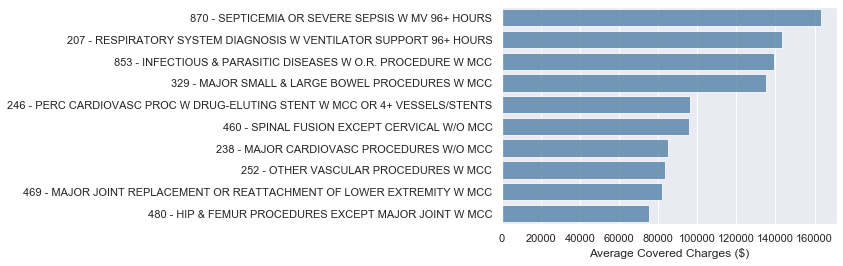

<Figure size 1080x1080 with 0 Axes>

In [45]:
%%capture --no-stdout --no-display output
# prevent warning message from showing
fig,ax= plt.subplots()
fig = sns.barplot(a.iloc[:,0],a.index, color="steelblue",alpha=0.8)
ax.set(ylabel=None)
plt.xlabel("Average Covered Charges ($)")
plt.figure(figsize=(15,15))

**Conclusion**: This features provides the insights of hospital bill for different procedures. From that, we could detect any unsual charge for specific procedure.

#### 12: Common Procedures by Region
This feature calculates the total cases of all procedures in each region

In [46]:
common_drug =  payment_data[['Region', 'DRG Definition']].groupby(by=['Region','DRG Definition']).agg({'DRG Definition': 'count'})

In [47]:
common_drug[:20]

DRG Definition
Region  DRG Definition                                                    
Midwest 039 - EXTRACRANIAL PROCEDURES W/O CC/MCC                       295
        057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/O...             292
        064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFAR...             396
        065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFAR...             548
        066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFAR...             438
        069 - TRANSIENT ISCHEMIA                                       468
        074 - CRANIAL & PERIPHERAL NERVE DISORDERS W/O MCC             245
        101 - SEIZURES W/O MCC                                         374
        149 - DYSEQUILIBRIUM                                           273
        176 - PULMONARY EMBOLISM W/O MCC                               373
        177 - RESPIRATORY INFECTIONS & INFLAMMATIONS W MCC             443
        178 - RESPIRATORY INFECTIONS & INFLAMMATIONS W CC              453
        189 - PULMONARY EDEMA & RESPIRATORY FAILURE                    515
        190 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W MCC              637
        191 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W CC               643
        192 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W/O...             621
        193 - SIMPLE PNEUMONIA & PLEURISY W MCC                        618
        194 - SIMPLE PNEUMONIA & PLEURISY W CC                         711
        195 - SIMPLE PNEUMONIA & PLEURISY W/O CC/MCC                   605
        202 - BRONCHITIS & ASTHMA W CC/MCC                             298

**Conclusion**: This feature can be used to identify non-common procedures and common procedures in each region, thus giving us an idea of what procedures are most common in each region. Therefore, we would be able to take closer look to different price point by provider for common procedures and  non-common procedures in order to detect fraud.

#### 13: Differences in Average Total Payment
This feature is the differences between maximum and minimum payments for each procedure

In [48]:
differences = payment_data[['DRG Definition','Average Total Payments']].groupby(by='DRG Definition').agg(['max','min'])
differences['Difference'] = differences[('Average Total Payments','max')] - differences[('Average Total Payments','min')]
differences = differences[:20].sort_values(by='Difference',ascending=False)
# the results were limited to the first 20 values, but can be changed to include as many or as little as needed by adjusting the range

<Figure size 1080x1080 with 0 Axes>

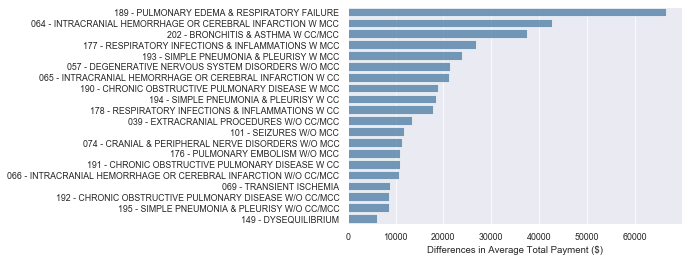

<Figure size 1080x1080 with 0 Axes>

In [49]:
%%capture --no-stdout --no-display output
# prevent warning message from showing

sns.set_context("paper")
ax = sns.barplot(differences["Difference"],differences.index, color="steelblue",alpha=0.8)
ax.set(ylabel=None)
plt.xlabel("Differences in Average Total Payment ($)")
plt.figure(figsize=(15,15))

**Conclusion**: This feature helps to identify the difference in payment for the same procedure. If the difference is high for a procedure, it means that the payment varies largely between different states or different providers. Thus, we need to investigate further for these procedures. 

### Part 2: Clustering
In this part, I use K-means clustering algorithm to explore the dataset, following the steps below:

    - Drop irrelevant variables
    - Standardization of Numerical / Float variables
    - k-means Clustering
    - Visualizing the results
    - Explain the anomalies

#### Payment data contains 19 mixed features of numerical and categorical columns. 

In [50]:
payment_data = payment_data.drop(columns = ['Provider Id'])

In [51]:
features = payment_data

In [52]:
%%capture --no-stdout --no-display output
features = features.merge(differences, on = "DRG Definition", how = "left")

In [53]:
# dtop Ave max and min here and keep difference
features.head()

,DRG Definition,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,Average Total Payments,...,Region,Ave Out of Pocket Payment,Ave OoP per discharge,Percent of Payment Covered,Medicare Coverage Ratio,Z-score Average Total Payments,Z-score Average Medicare Payments,"(Average Total Payments, max)","(Average Total Payments, min)","(Difference, )"
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,...,South,1013.51,11.137473,17.53,0.824568,-0.512776,-0.510403,18420.56,4968.0,13452.56
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,...,South,810.86,57.918571,38.25,0.859896,-0.511428,-0.481265,18420.56,4968.0,13452.56
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,...,South,981.16,40.881667,14.47,0.819472,-0.557435,-0.552805,18420.56,4968.0,13452.56
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,...,South,1288.40,51.536000,38.70,0.762181,-0.559703,-0.597218,18420.56,4968.0,13452.56
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,...,South,806.89,44.827222,17.89,0.857398,-0.528290,-0.498403,18420.56,4968.0,13452.56


In [54]:
features.rename(columns={('Average Total Payments', 'max'):'max',
                         ('Average Total Payments', 'min'): 'min',
                         ('Difference', ''): 'Differences'
                        }, inplace=True)

In [55]:
features.drop(
    ['min', 'max'],
    axis=1, inplace=True)

In [56]:
# not doing this one because the df only has the medicare coverage ratio columns, this one provides information 
## of coverage ratio by state.
features = features.merge(med_cv_state, on = "Provider State", how = "left")

In [57]:
features = features.merge(patient_avg_state, on = "Provider State", how= "left")

In [58]:
# Rename the last 4 columns as Ave by state
features.head()

,DRG Definition,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges_x,Average Covered Charges_x,Average Total Payments_x,...,Percent of Payment Covered,Medicare Coverage Ratio_x,Z-score Average Total Payments,Z-score Average Medicare Payments,Differences,Medicare Coverage Ratio_y,Total Discharges_y,Average Covered Charges_y,Average Total Payments_y,Average Medicare Payments_y
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,...,17.53,0.824568,-0.512776,-0.510403,13452.56,0.816622,39.258322,31316.462074,7568.232149,6418.00712
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,...,38.25,0.859896,-0.511428,-0.481265,13452.56,0.816622,39.258322,31316.462074,7568.232149,6418.00712
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,...,14.47,0.819472,-0.557435,-0.552805,13452.56,0.816622,39.258322,31316.462074,7568.232149,6418.00712
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,...,38.70,0.762181,-0.559703,-0.597218,13452.56,0.816622,39.258322,31316.462074,7568.232149,6418.00712
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,...,17.89,0.857398,-0.528290,-0.498403,13452.56,0.816622,39.258322,31316.462074,7568.232149,6418.00712


In [59]:
features = features.rename(columns={"Total Discharges_x": "Total_Discharges", 
                                   "Average Covered Charges_x": "Ave_Covered_Charges",
                                   "Average Total Payments_x": "Ave_Total_Payments",
                                   "Average Medicare Payments_x":"Aver_Medicare_Payments",
                                   "Ave Out of Pocket Payment":"Ave_OOP",
                                   "Percent of Payment Covered" : "Prop_payment_covered",
                                   "Medicare Coverage Ratio_x":"Medicare_Coverage_Ratio",
                                   "Z-score Average Total Payments": "Zscore_ave_total_payment",
                                   "Z-score Average Medicare Payments": "Zscore_ave_medicare_payment",
                                   "Total Discharges_y":"Mean_Total_Discharge_bystate", 
                                   "Average Covered Charges_y":"Mean_Ave_Covered_bystate",
                                  "Average Total Payments_y":"Mean_Ave_Total_Payment_bystate",
                                  "Average Medicare Payments_y":"Mean_Ave_Medicare_bystate"})

#### *Note*
K-means only works with numerical columns and there are more than 50 unique values in categorical columns like DRG definition, Provider ID, provider name, provider city, provider state, provider zipcode, hospital referral regions. Therefore, one hot encoder doesn't make significant support to clustering method. Additionally, using one hot encoding creates many different new binary features which does not apply to K-mean clustering accurately.  Therefore, all categorical columns are decided to drop.

In [60]:
categorical_col = features.loc[:, features.dtypes == np.object]
a = categorical_col.columns
features = features.drop(columns = a)

In [61]:
features.columns

Index(['Total_Discharges', 'Ave_Covered_Charges', 'Ave_Total_Payments',
       'Aver_Medicare_Payments', 'Ave_OOP', 'Ave OoP per discharge',
       'Prop_payment_covered', 'Medicare_Coverage_Ratio',
       'Zscore_ave_total_payment', 'Zscore_ave_medicare_payment',
       'Differences', 'Medicare Coverage Ratio_y',
       'Mean_Total_Discharge_bystate', 'Mean_Ave_Covered_bystate',
       'Mean_Ave_Total_Payment_bystate', 'Mean_Ave_Medicare_bystate'],
      dtype='object')

In [62]:
features.isnull().sum()

Total_Discharges                       0
Ave_Covered_Charges                    0
Ave_Total_Payments                     0
Aver_Medicare_Payments                 0
Ave_OOP                                0
Ave OoP per discharge                  0
Prop_payment_covered                   0
Medicare_Coverage_Ratio                0
Zscore_ave_total_payment               0
Zscore_ave_medicare_payment            0
Differences                       124528
Medicare Coverage Ratio_y              0
Mean_Total_Discharge_bystate           0
Mean_Ave_Covered_bystate               0
Mean_Ave_Total_Payment_bystate         0
Mean_Ave_Medicare_bystate              0
dtype: int64

With a large amount of missing values in differences column, it does not have significant impact to the model after imputing missing values

In [63]:
features['Differences'].isnull().sum()/len(features)

0.7636709287707356

In [64]:
features = features.drop(columns = ['Differences'])

### Correlation

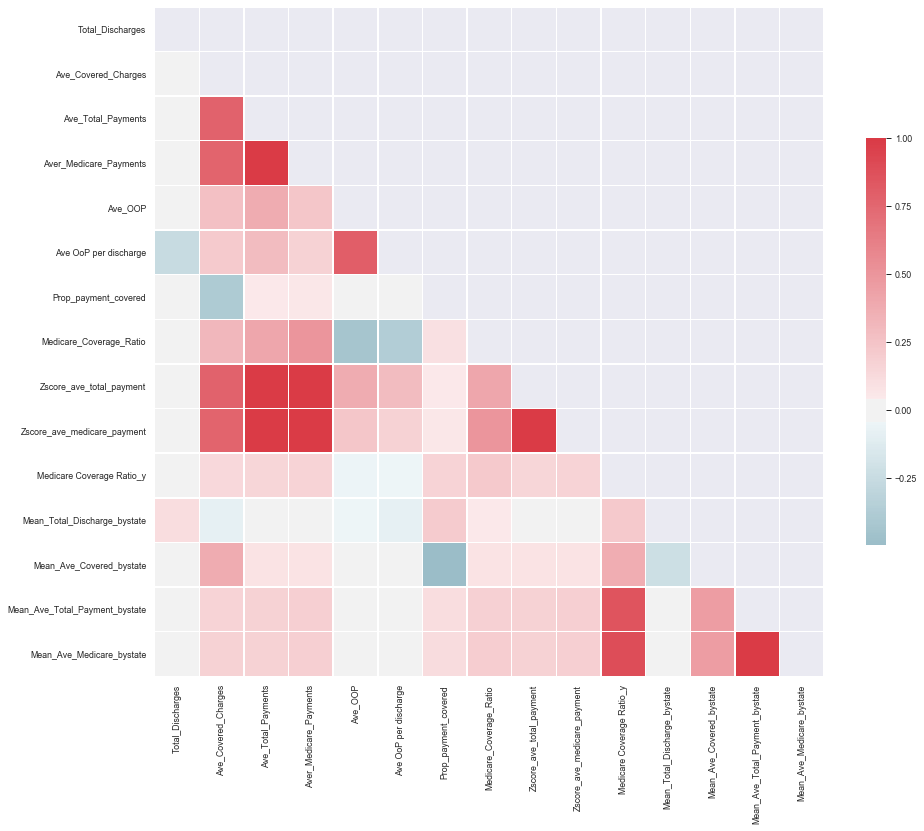

In [65]:
corr = features.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In general, feautures that are too correlated do not improve model efficiency and also affect the performance of linear regression and random forest models, making the learning algorithms slower to create and train. Therefore, I removed highly correlated features to prevent multicollinearity trhough the following function:

In [66]:
# Function to remove columns with high correlation value
def correlation(dataset, threshold):
    """
    Remove columns that do exceeed correlation threshold
    """
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return(dataset)

In [67]:
features = correlation(features, 0.8)

In [68]:
features.columns

Index(['Total_Discharges', 'Ave_Covered_Charges', 'Ave_Total_Payments',
       'Ave_OOP', 'Ave OoP per discharge', 'Prop_payment_covered',
       'Medicare_Coverage_Ratio', 'Medicare Coverage Ratio_y',
       'Mean_Total_Discharge_bystate', 'Mean_Ave_Covered_bystate'],
      dtype='object')

#### Standardize all features

In [69]:
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler()
X = sc.fit_transform(features)

In [70]:
X = pd.DataFrame(data = features, columns = features.columns)
X.head()


,Total_Discharges,Ave_Covered_Charges,Ave_Total_Payments,Ave_OOP,Ave OoP per discharge,Prop_payment_covered,Medicare_Coverage_Ratio,Medicare Coverage Ratio_y,Mean_Total_Discharge_bystate,Mean_Ave_Covered_bystate
0,91,32963.07,5777.24,1013.51,11.137473,17.53,0.824568,0.816622,39.258322,31316.462074
1,14,15131.85,5787.57,810.86,57.918571,38.25,0.859896,0.816622,39.258322,31316.462074
2,24,37560.37,5434.95,981.16,40.881667,14.47,0.819472,0.816622,39.258322,31316.462074
3,25,13998.28,5417.56,1288.40,51.536000,38.70,0.762181,0.816622,39.258322,31316.462074
4,18,31633.27,5658.33,806.89,44.827222,17.89,0.857398,0.816622,39.258322,31316.462074


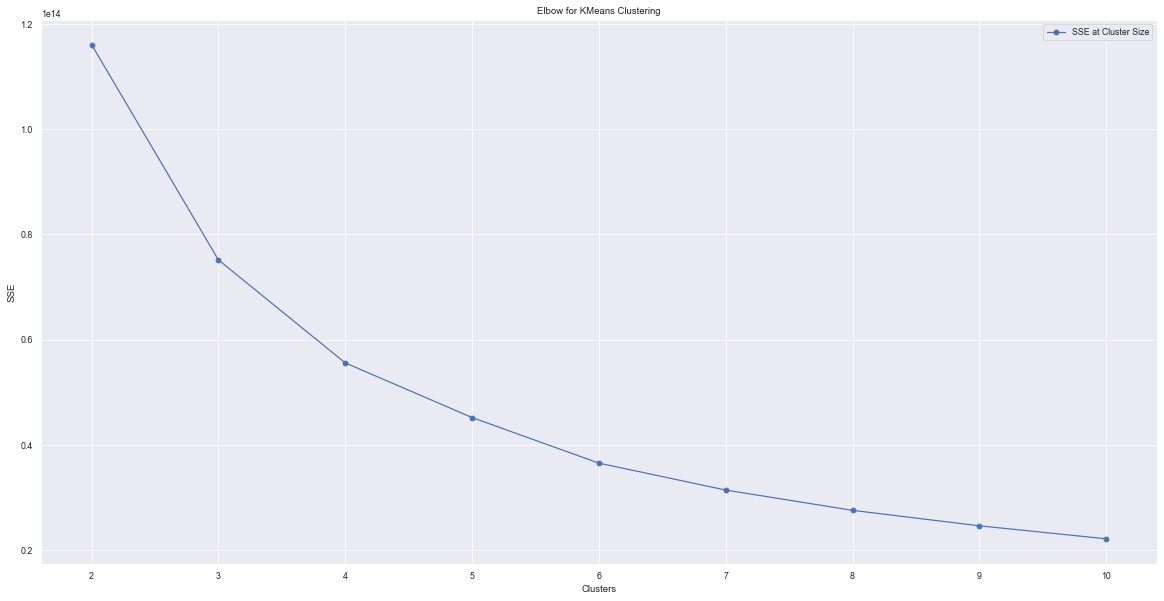

In [71]:
from sklearn.cluster import KMeans
    
k_range = range(2,11)
sse = []
for k in k_range:
  clusterer = KMeans(n_clusters=k, random_state=0)
  cluster_labels = clusterer.fit(X)
  sse.append(clusterer.inertia_)

fig = plt.figure(figsize=(20,10))
plt.plot(k_range, sse, "-o", label = "SSE at Cluster Size", )
plt.xlabel("Clusters")
plt.ylabel("SSE")
plt.title("Elbow for KMeans Clustering")
plt.legend()
plt.show()

From the elbow chart above, the ideal number of clusters is somewhat hard to determine. Both 6 and 8 seems like good places to start.

*Note* - the SSE values are scaled, i.e. 0.8 on the chart is equal to 0.8\*1e14 

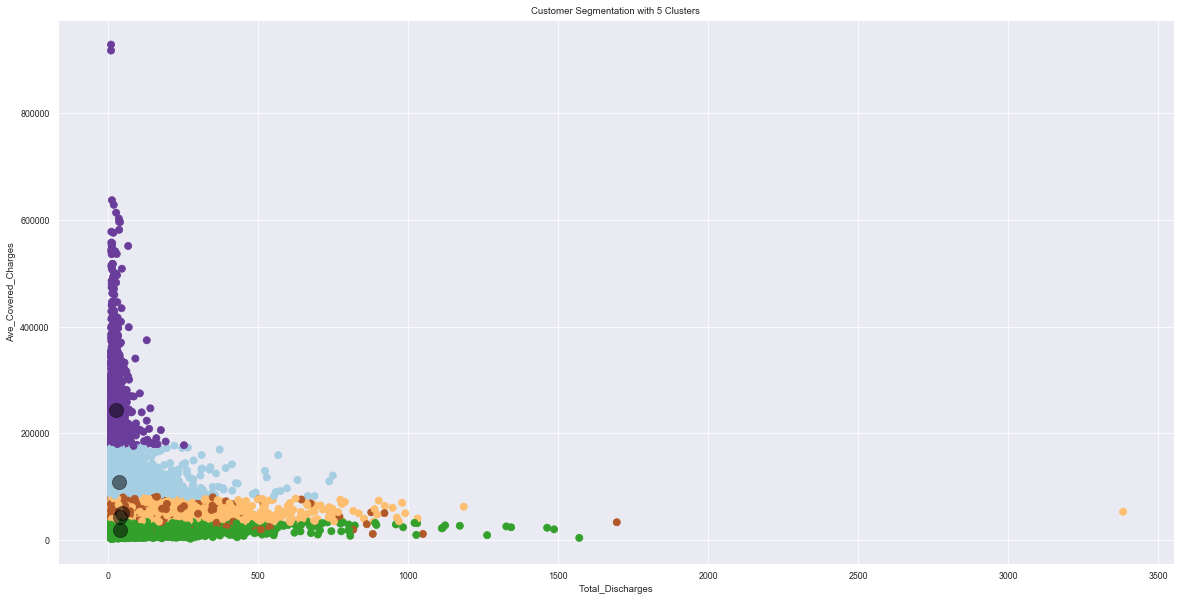

In [72]:
# generating scatter plot for predictions
km5 = KMeans(n_clusters = 5, init ='k-means++', max_iter=300, n_init=10,random_state=0)
y_mean = km5.fit_predict(X)

plt.figure(figsize=(20, 10))  
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_mean, cmap='Paired', s=50)
plt.title('Customer Segmentation with 5 Clusters')
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])

centers = km5.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

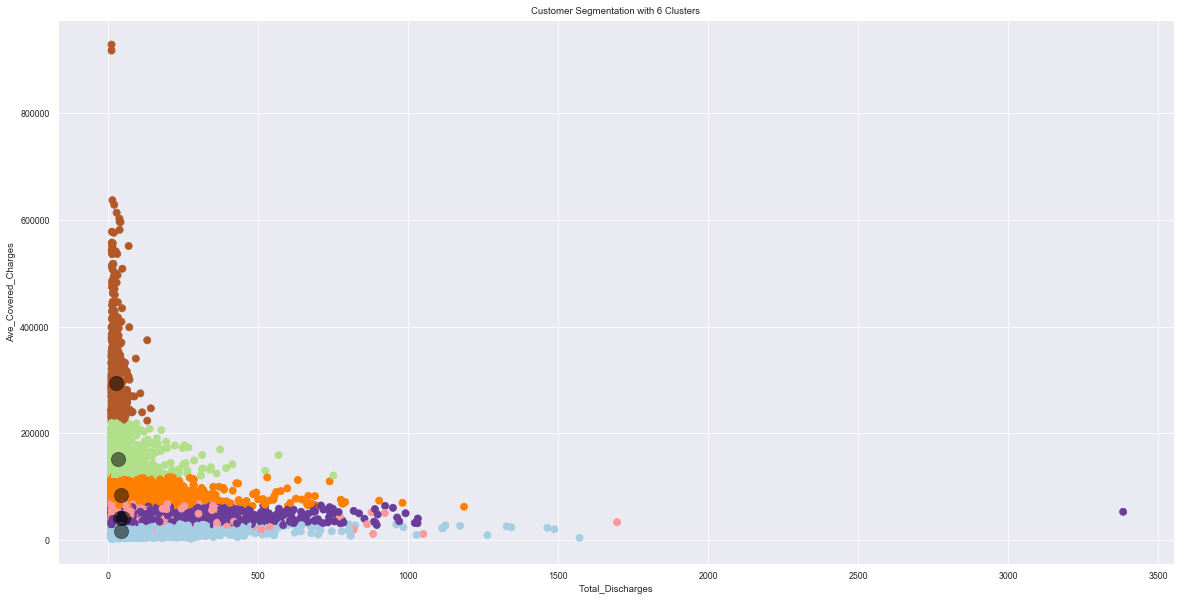

In [73]:
# generating scatter plot for predictions
km1 = KMeans(n_clusters = 6, init ='k-means++', max_iter=300, n_init=10,random_state=0)
y_mean = km1.fit_predict(X)

plt.figure(figsize=(20, 10))  
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_mean, cmap='Paired', s=50)
plt.title('Customer Segmentation with 6 Clusters')
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])

centers = km1.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

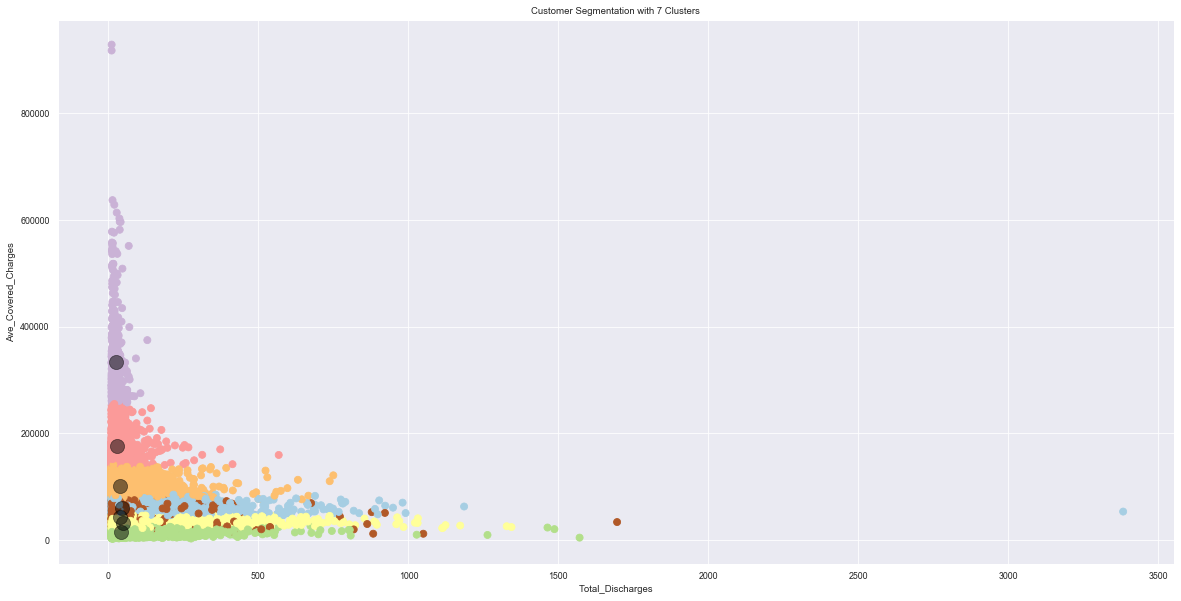

In [74]:
# generating scatter plot for predictions
km2 = KMeans(n_clusters = 7, init ='k-means++', max_iter=300, n_init=10,random_state=0)
y_mean = km2.fit_predict(X)

plt.figure(figsize=(20, 10))  
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_mean, cmap='Paired', s=50)
plt.title('Customer Segmentation with 7 Clusters')
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])

centers = km2.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

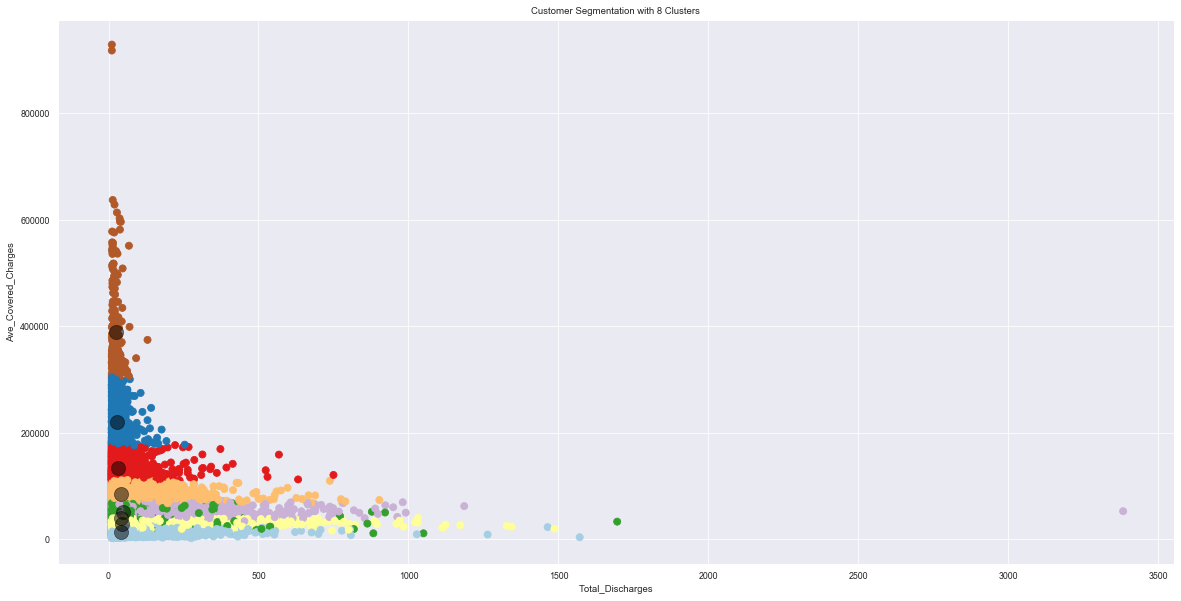

In [75]:
# generating scatter plot for predictions
km3 = KMeans(n_clusters = 8, init ='k-means++', max_iter=300, n_init=10,random_state=0)
y_mean = km3.fit_predict(X)

plt.figure(figsize=(20, 10))  
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_mean, cmap='Paired', s=50)
plt.title('Customer Segmentation with 8 Clusters')
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])

centers = km3.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

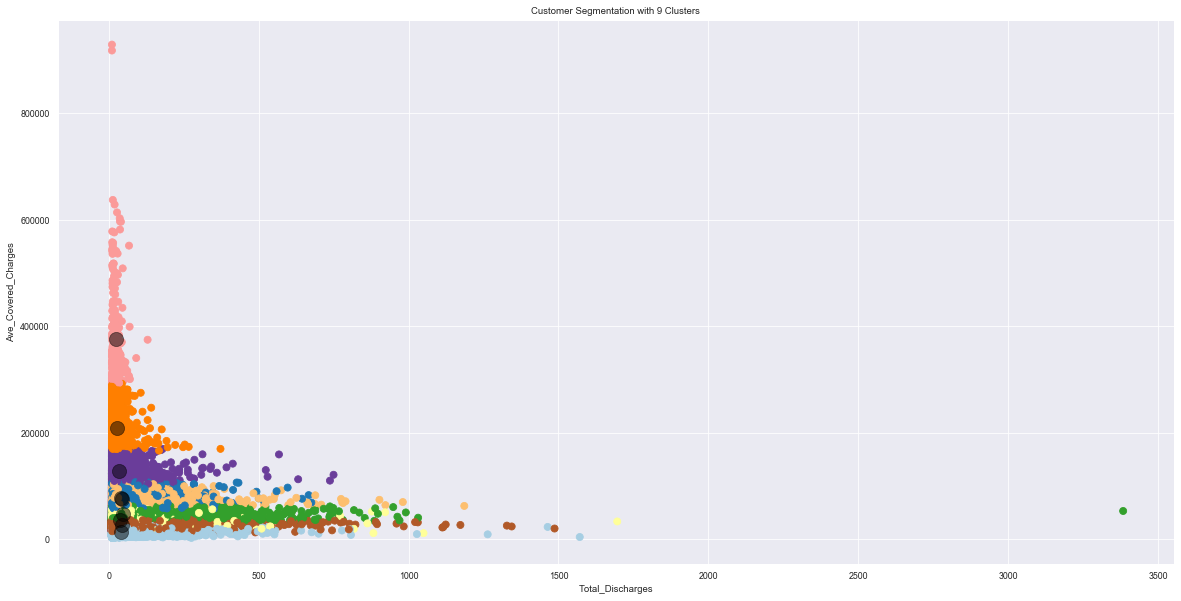

In [76]:
# generating scatter plot for predictions
km3 = KMeans(n_clusters = 9, init ='k-means++', max_iter=300, n_init=10,random_state=0)
y_mean = km3.fit_predict(X)

plt.figure(figsize=(20, 10))  
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_mean, cmap='Paired', s=50)
plt.title('Customer Segmentation with 9 Clusters')
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])

centers = km3.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

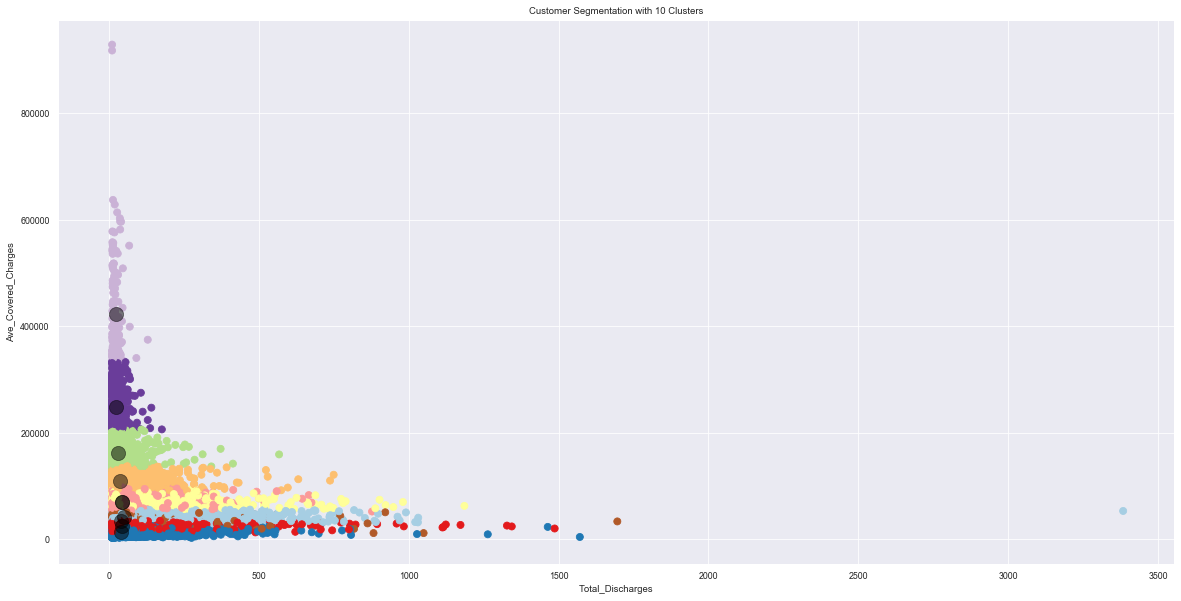

In [77]:
# generating scatter plot for predictions
km3 = KMeans(n_clusters = 10, init ='k-means++', max_iter=300, n_init=10,random_state=0)
y_mean = km3.fit_predict(X)

plt.figure(figsize=(20, 10))  
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_mean, cmap='Paired', s=50)
plt.title('Customer Segmentation with 10 Clusters')
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])

centers = km3.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

#### Indecipherable Visualizations

As the model takes 11 features and creates results in an 11-dimensional space, it does not translate well when attempting to display it through a 2-d graph. Therefore, I will use silhouette scores to help determine the best number of clusters.

##### *Note*
The ranges for the silhouette scores were spread across 3 cells: 
    - first range [2:4]
    - second range [5:10]
    - third range [11:12]
The code takes some time to run for every K number and I wanted to explore the data further without spending time rerunning code.

For n_clusters = 2 The average silhouette_score is : 0.6754436345864707
For n_clusters = 3 The average silhouette_score is : 0.5604495050464645
For n_clusters = 4 The average silhouette_score is : 0.4821517741483471


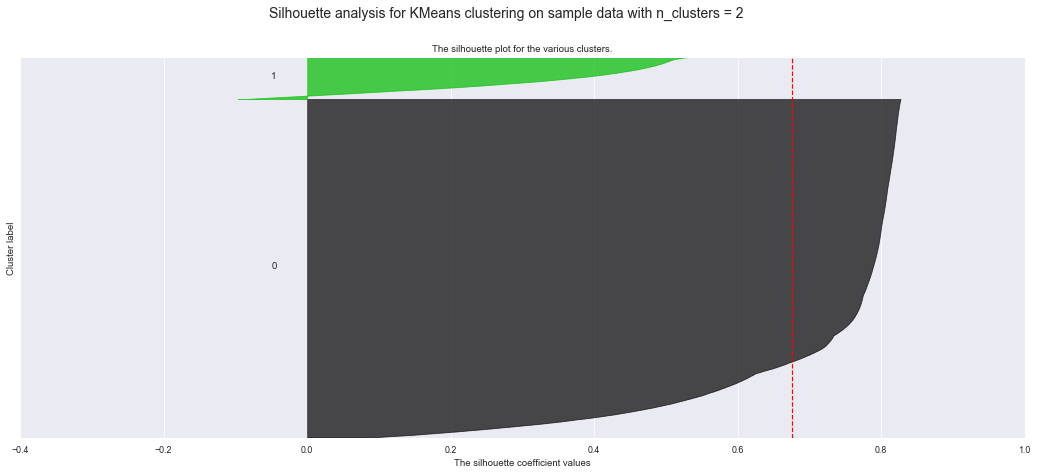

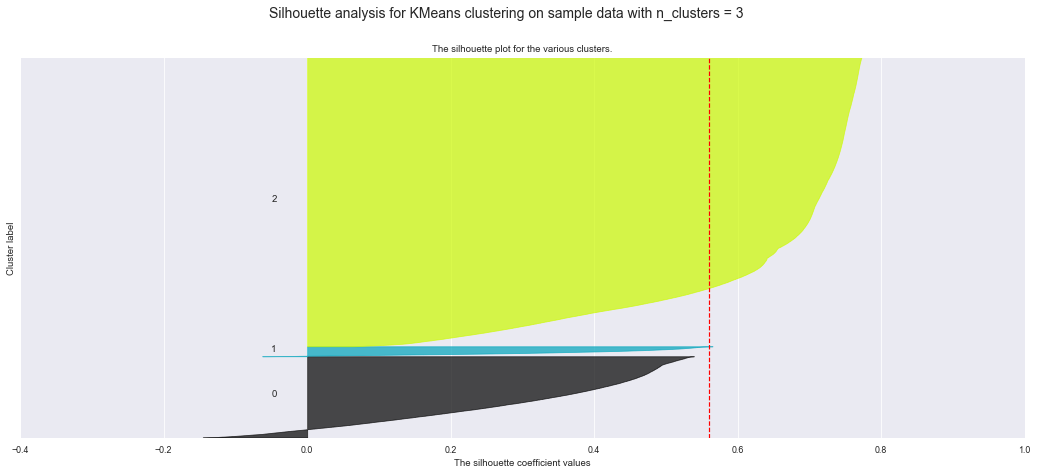

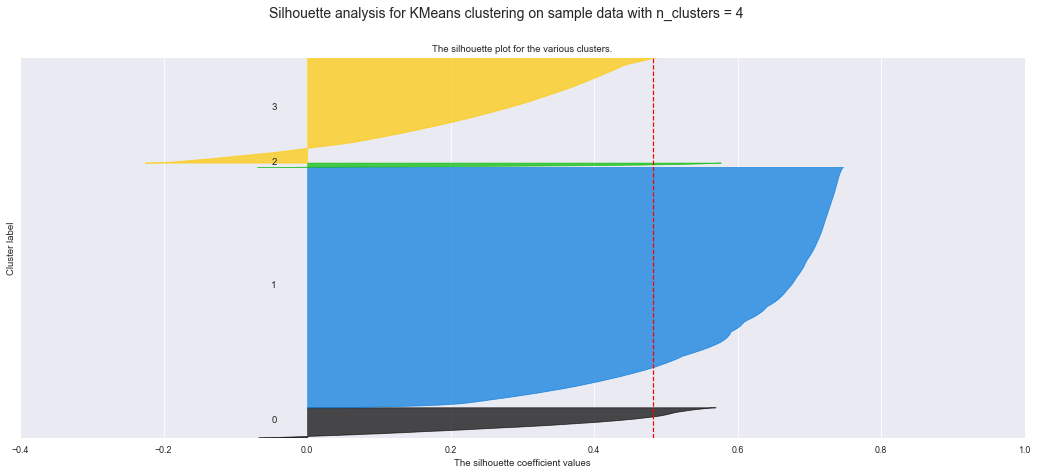

In [85]:
# Choose range off elbows in above chart and optimized by observing generated charts
range_n_clusters = [2,3,4]

for n_clusters in range_n_clusters:
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # No silhouette coefficient was smaller than -0.3, so limited graph to this range for easier viewing 
    ax1.set_xlim([-0.4, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    # Determing the silouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    # iterate through number of clusters
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate values
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14)

plt.show()

For n_clusters = 5 The average silhouette_score is : 0.5069573045577488
For n_clusters = 6 The average silhouette_score is : 0.46466229986346946
For n_clusters = 7 The average silhouette_score is : 0.3977982689708172
For n_clusters = 8 The average silhouette_score is : 0.37274497497270376
For n_clusters = 9 The average silhouette_score is : 0.364913379892289
For n_clusters = 10 The average silhouette_score is : 0.35349254345463216


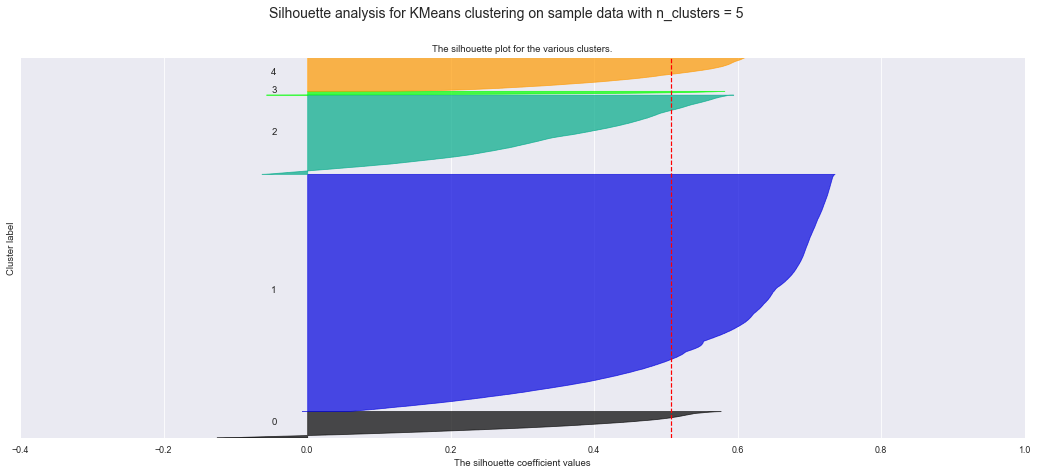

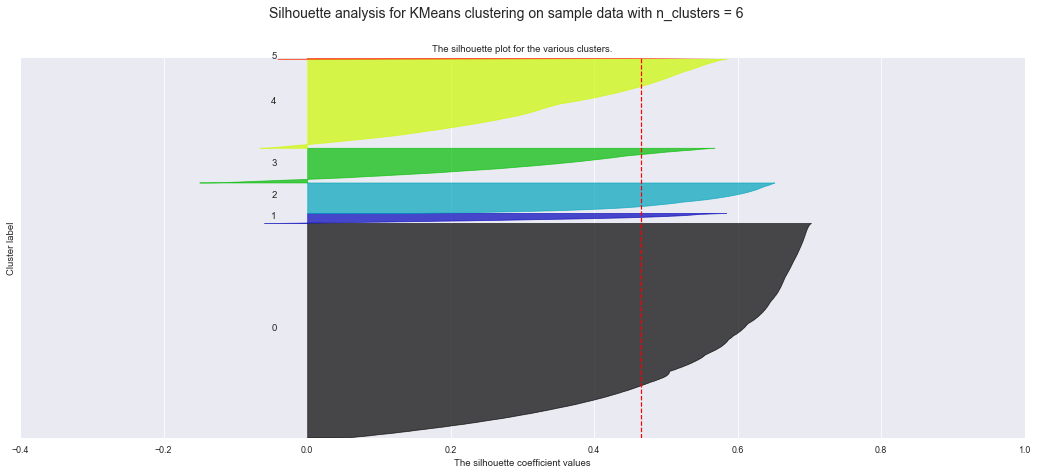

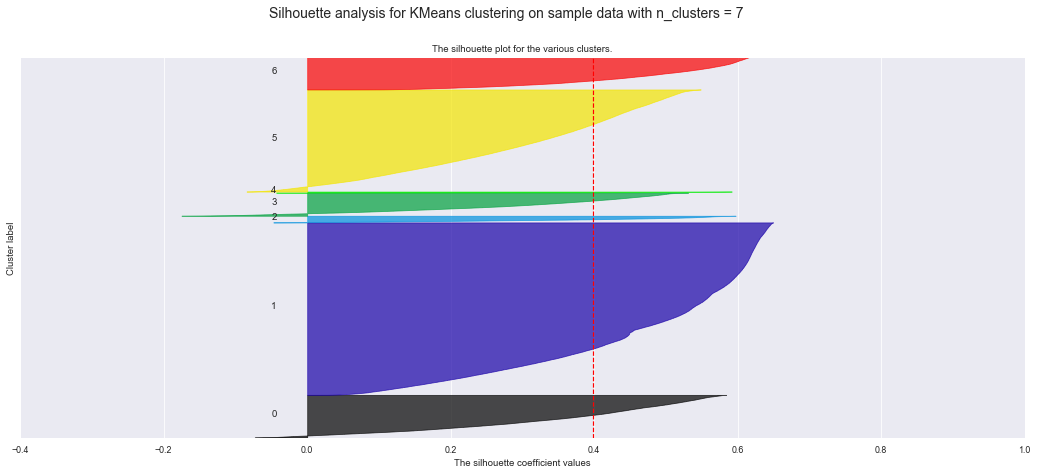

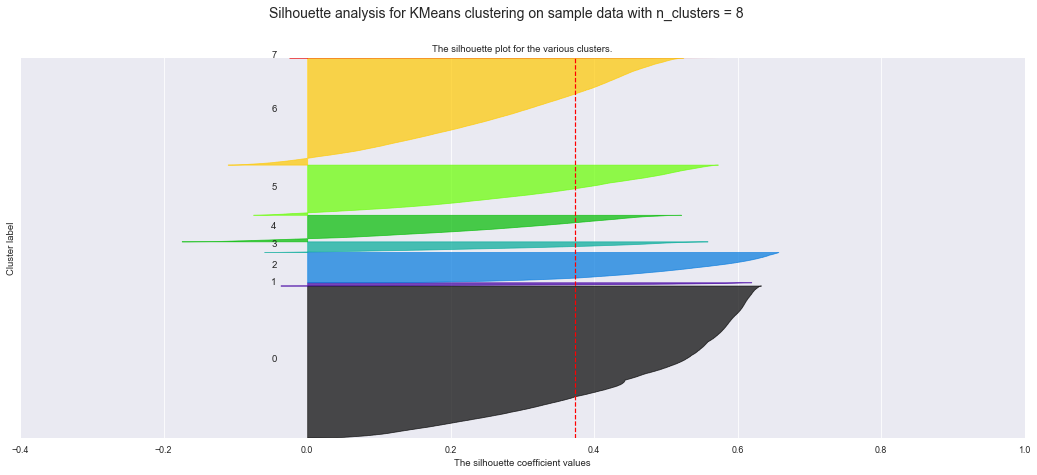

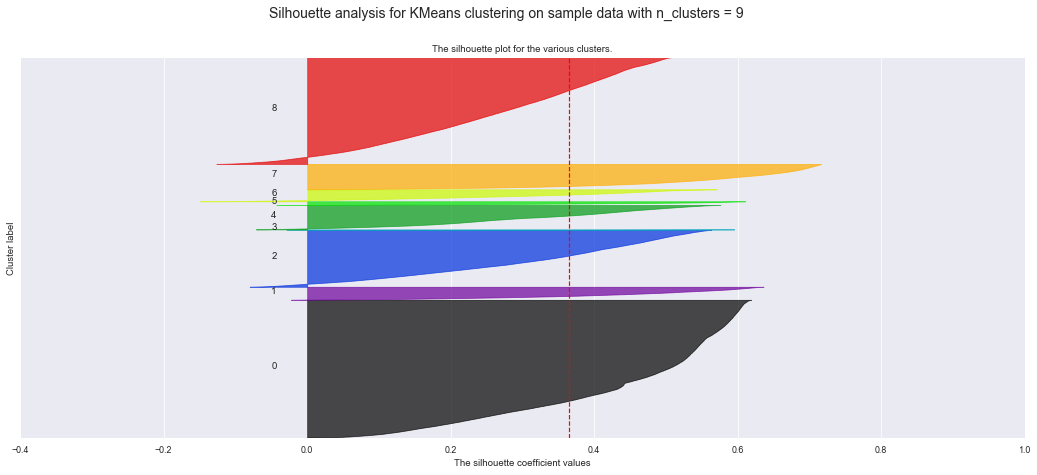

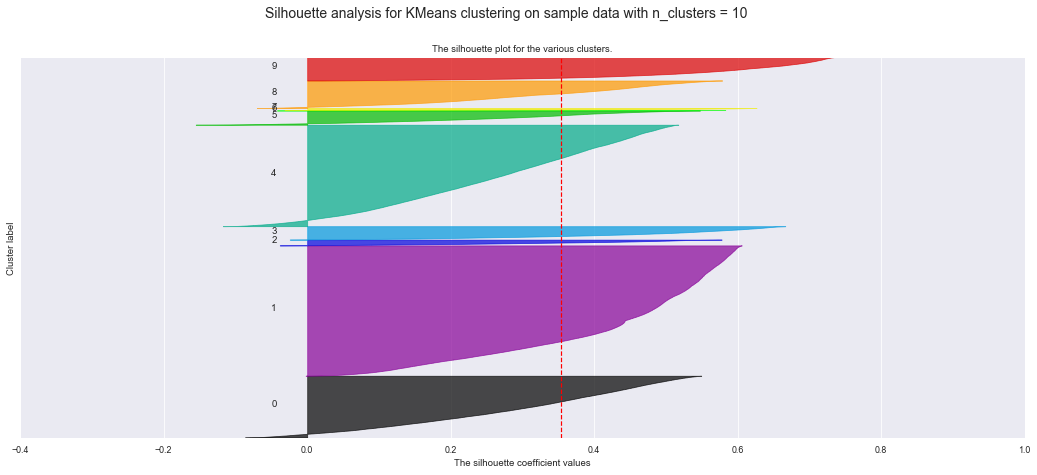

In [78]:
# Adapted from SKLearn silhouette docs

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


# Choose range off elbows in above chart and optimized by observing generated charts
range_n_clusters = [5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # No silhouette coefficient was smaller than -0.3, so limited graph to this range for easier viewing 
    ax1.set_xlim([-0.4, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    # Determing the silouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    # iterate through number of clusters
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate values
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14)

plt.show()

For n_clusters = 11 The average silhouette_score is : 0.3746648376888015
For n_clusters = 12 The average silhouette_score is : 0.3746603450407584


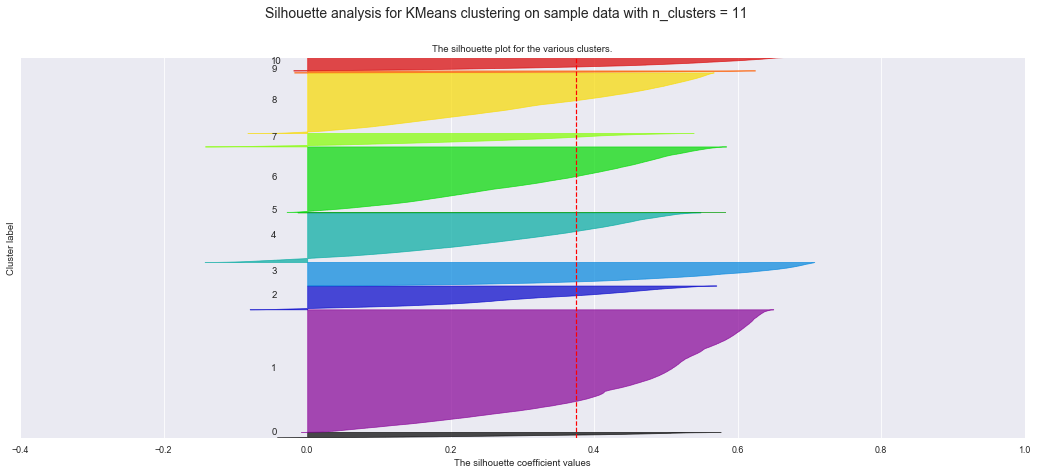

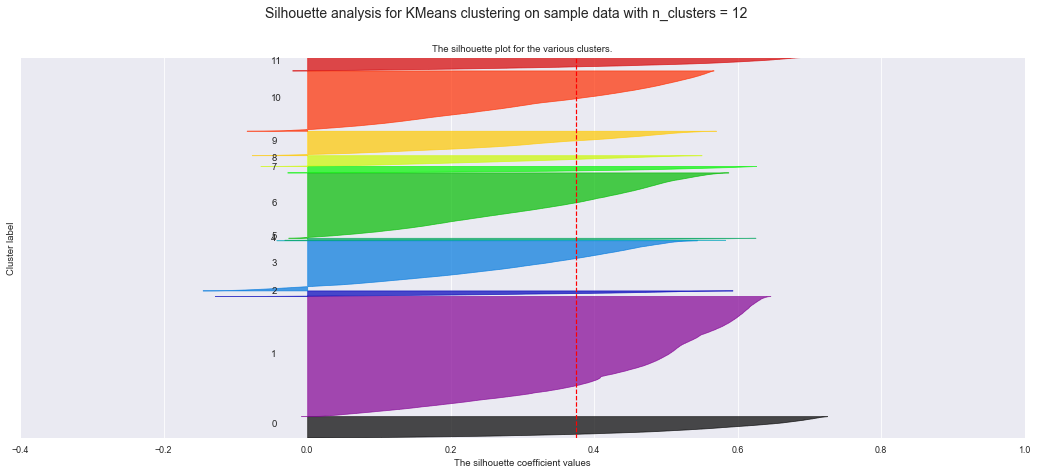

In [86]:
# Choose range off elbows in above chart and optimized by observing generated charts
range_n_clusters = [11,12]

for n_clusters in range_n_clusters:
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # No silhouette coefficient was smaller than -0.3, so limited graph to this range for easier viewing 
    ax1.set_xlim([-0.4, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    # Determing the silouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    # iterate through number of clusters
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate values
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14)

plt.show()

Overall, there is not a sample that overwhelmingly stands out from the others. When using silhouette scores, it is important to note the height represented for each cluster as they should have similar sizes and that they should at least the average silhouette score.
<br><br>
From the clusters that range from 2 to 12, all of the clusters at least meet the average silhoutte score, but size is a less clear metric. In all of the cluster sizes, there is a disproportionately large cluster in either cluster 0 or 1. As this characteristic is noted in all the clusters, it may mean that the data is just weighted more heavily to create it. However, as the data set is not neatly balanced, it makes sense that there may be a major change in size from one cluster to another.
<br><br>
Instead of relying on one method solely, using a hybrid approach and choosing off the silhouettes and the k-means elbows will provide a better indication of what cluster to use. Therefore, 6 clusters will be used moving forward.


### Analysis for k=6 Clusters

In [79]:
km1 = KMeans(n_clusters = 6, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
km1.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [80]:
cluster = km1.labels_
features['cluster'] = km1.labels_
payment_data['cluster'] = km1.labels_

In [81]:
cluster_eda = payment_data.groupby('cluster').mean().reset_index()

In [82]:
cluster_eda['Proportion_by_cluster'] = (payment_data['cluster'].value_counts() / payment_data['cluster'].value_counts().sum()) * 100

In [83]:
cluster_eda

,cluster,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,Ave Out of Pocket Payment,Ave OoP per discharge,Percent of Payment Covered,Medicare Coverage Ratio,Z-score Average Total Payments,Z-score Average Medicare Payments,Proportion_by_cluster
0,0,41.769673,17435.133711,6418.865009,5395.872294,1022.992715,42.062905,40.278640,0.822227,-0.429064,-0.423920,56.365866
1,1,31.422819,151401.620988,31154.406327,28715.057334,2439.348993,113.093816,20.853819,0.920858,2.798173,2.766361,2.649864
2,2,40.188552,40706.009778,8065.669566,7052.031639,1013.637927,42.735734,21.259141,0.858268,-0.214206,-0.197342,8.013982
3,3,41.350454,84755.816998,18753.381037,16986.323877,1767.057161,73.137638,22.391985,0.899876,1.180216,1.161762,9.109864
4,4,48.309773,42256.437151,11441.088421,10086.390332,1354.698089,52.409169,27.414836,0.869899,0.226184,0.217787,23.374115
5,5,24.706179,294909.832560,48288.973745,45643.175259,2645.798487,134.121650,16.731160,0.945507,5.033714,5.082285,0.486309


#### Anomaly Detection

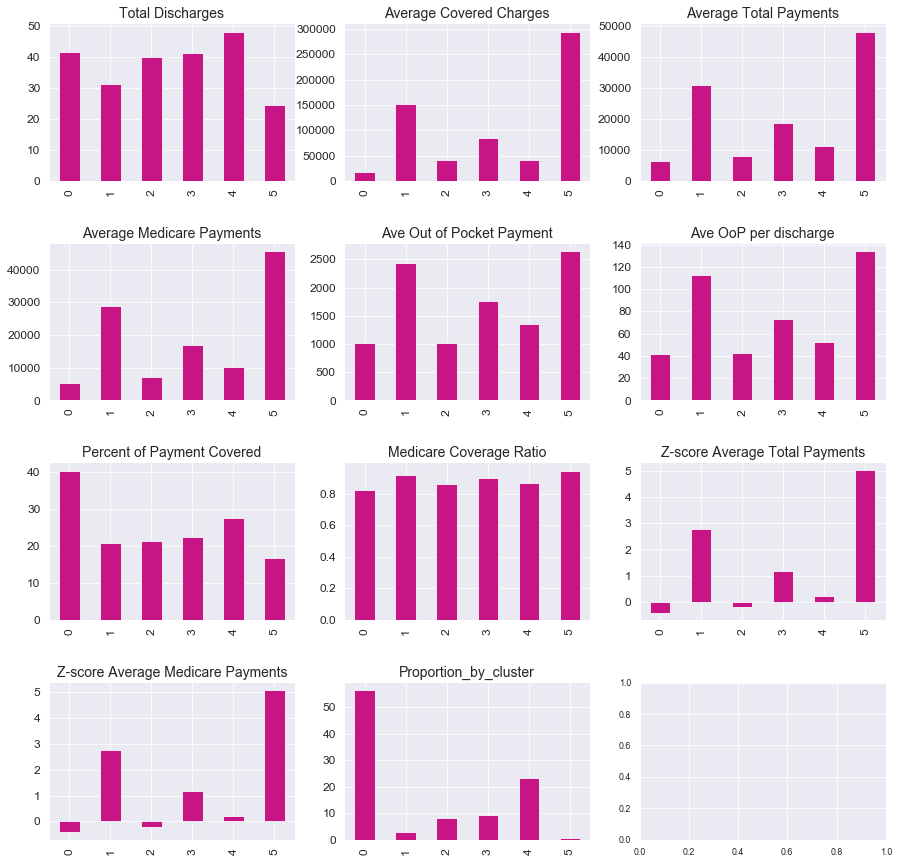

In [84]:
fig, axarr = plt.subplots(4, 3, figsize=(15, 15))

cluster_eda['Total Discharges'].plot.bar(
    ax=axarr[0][0], fontsize=12, color='mediumvioletred'
)
axarr[0][0].set_title("Total Discharges", fontsize=14)

cluster_eda['Average Covered Charges'].plot.bar(
    ax=axarr[0][1], fontsize=12, color='mediumvioletred'
)
axarr[0][1].set_title("Average Covered Charges", fontsize=14)

cluster_eda['Average Total Payments'].plot.bar(
    ax=axarr[0][2], fontsize=12, color='mediumvioletred'
)
axarr[0][2].set_title("Average Total Payments", fontsize=14)

cluster_eda['Average Medicare Payments'].plot.bar(
    ax=axarr[1][0], fontsize=12, color='mediumvioletred'
)
axarr[1][0].set_title("Average Medicare Payments", fontsize=14)

cluster_eda['Ave Out of Pocket Payment'].plot.bar(
    ax=axarr[1][1], fontsize=12, color='mediumvioletred'
)
axarr[1][1].set_title("Ave Out of Pocket Payment", fontsize=14)

cluster_eda['Ave OoP per discharge'].plot.bar(
    ax=axarr[1][2], fontsize=12, color='mediumvioletred'
)
axarr[1][2].set_title("Ave OoP per discharge", fontsize=14)

cluster_eda['Percent of Payment Covered'].plot.bar(
    ax=axarr[2][0], fontsize=12, color='mediumvioletred'
)
axarr[2][0].set_title("Percent of Payment Covered", fontsize=14)

cluster_eda['Medicare Coverage Ratio'].plot.bar(
    ax=axarr[2][1], fontsize=12, color='mediumvioletred'
)
axarr[2][1].set_title("Medicare Coverage Ratio", fontsize=14)
plt.subplots_adjust(hspace=.3)

cluster_eda['Z-score Average Total Payments'].plot.bar(
    ax=axarr[2][2], fontsize=12, color='mediumvioletred'
)
axarr[2][2].set_title("Z-score Average Total Payments", fontsize=14)

cluster_eda['Z-score Average Medicare Payments'].plot.bar(
    ax=axarr[3][0], fontsize=12, color='mediumvioletred'
)
axarr[3][0].set_title("Z-score Average Medicare Payments", fontsize=14)

cluster_eda['Proportion_by_cluster'].plot.bar(
    ax=axarr[3][1], fontsize=12, color='mediumvioletred'
)
axarr[3][1].set_title("Proportion_by_cluster", fontsize=14)

plt.subplots_adjust(hspace=.4)

import seaborn as sns
sns.despine()

From the 11 features used for clustering, 6 different clusters were created. The charts above detail information regarding to mean of all numeric features from the dataframe for each cluster. The key takeaways are as followings:

**Total Discharges**: Cluster 5 has a low mean value here compared to the others which should be a concern to detect anomalies. However, this cluster contains about 0.5% of the data which may explain its low result for total discharge. Similalry, but not to the same extent, cluster 1 is also affected through its low proportion of data. 

**Average Covered Charges**: Cluster 5 has an extremely high value for the mean of average covered charge, totaling of approximately \\$300k which is concerning when comparing its size with other clusters. Cluster 1 also has a high value here which of about \\$150k. These two clusters seem to contain anomalies/supicious transactions. 

**Average Total Payments**: Similarly to *Average Covered Charges*, Cluster 5 an Cluster 1 have high values of \\$50k and \\$30k respectively. These facts are suspicious considering their size in the dataset. 

**Average Medicare Payments**: Again, Cluster 5 has a large difference compared to the others clusters and almost doubles the amount for cluster 1 and is 10 times larger than cluster 0. This is a great concern as cluster 5 contains a small amount of the data points but its average medicare payments is significantly higher. Cluster 1 should also be treated similarly.

**Average Out of Pocket Payments**: Cluster 5 and cluster 1 also have high values for out of pocket payment here but not significantly different from others. Other clusters pay around \\$1000-1500 while these two pay around \\$2500. However, as these amounts are still higher than the average, they should still be investigated.

**Average OOP per Discharge**: Cluster 5 has an extremely high value for the mean of average covered charge, at approximately \\$135, which is a large concern compared to other clusters. Cluster 1 also has a high value here which is about \\$115. These two clusters seem to contain anomalies or supicious transactions. 

**Percent of Payment Covered**: Cluster 0 has a high value which is almost double the values of the other clusters. This group indicates about 56% of the dataset however and has not been suspicious within other features, meaning it should be considered for anomalies, but may just be the shape of the data. 

**Medicare Coverage Ratio**: Overall, this feature is fairly even across all clusters and therefore has little to investigate. By observing how it affects the data and models, including it later on should be reconsidered.

**Z-score Average Total Payments**: An absolute Z-score greater than 3 are an outliers or anomalies as they fall outside 99.7% of the data and a Z-score of 2 representing 95% of the data . Group 5 (0.5% data point) has an extremely high z-score with a value around 5 and group 1 (2.6% data point) reaches right below 3. Therefore, greater examinination is needed for these clusters as they are anomalous. 

**Z Score Average Medicare Payments**: The pattern for the Z-scores of cluster 1 and cluster 5 follow the same pattern as their previous Z-scores and they should be investigated fully to determine the cause.

**Proportion per Cluster**: Overall, cluster 0 makes up over 50% of the data while cluster 4 makes up around 23%. When re-analyzing the clusters, further feature engineering should be considered to find ways to break up these groups. However, this may simple be the shape of the data and is not something that can be altered.







#### Conclusion

Overall, the cluster model contains 11 final features and generates 6 clusters. From those clusters, there are 2  that standout for anomaly detection: group 1 and group 5. As their means for most features are incredibly high and have z-scores that fall outside the normal range, they are highly suspect and may contain anomalous behaviour or outliers that need to be identified. Through monitoring these variables with these features and clusters, hopefully greater detection is realized to prevent any fraud. 